In [2]:
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from stop_words import get_stop_words
import shap
import warnings

warnings.filterwarnings("ignore")

In [3]:
romanian_texts = {}
moldavian_texts = {}

conn = sqlite3.connect('news.db')
c = conn.cursor()

c.execute('SELECT * FROM romania')
rows = c.fetchall()
for row in rows:
    if row[4] not in romanian_texts:
        romanian_texts[row[4]] = []
    romanian_texts[row[4]].append(row[5])
    
c.execute('SELECT * FROM moldova WHERE newspaper != "zugo"')
rows = c.fetchall()
for row in rows:
    text = ''
    if len(row[5]) > 10000:
        text = row[5][:10000]
    else:
        text = row[5]
    if row[4] not in moldavian_texts:
        moldavian_texts[row[4]] = []
        
    moldavian_texts[row[4]].append(text)

conn.close()

In [4]:
all_texts = {"romana": [], "moldova": []}

for key in romanian_texts:
    all_texts["romana"].extend(romanian_texts[key])

    
for key in moldavian_texts:
    all_texts["moldova"].extend(moldavian_texts[key])
    

In [15]:
!python -m spacy download ro_core_news_lg

/bin/bash: /home/alex/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.5/568.5 MB 6.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_lg')


In [24]:
# Extract most common parts of speech with spacy
import spacy

nlp = spacy.load('ro_core_news_md')

def get_most_common_pos(texts, n=10):
    pos = {}
    tokenized_texts = []
    for text in texts:
        doc = nlp(text)
        for token in doc:
            if token.pos_ not in pos:
                pos[token.pos_] = 0
            pos[token.pos_] += 1
            
        tokenized_texts.append([token.pos_ for token in doc])
        
    return [sorted(pos.items(), key=lambda x: x[1], reverse=True)[:n], tokenized_texts]

mc_romana, tk_romana = get_most_common_pos(all_texts["romana"])
mc_moldova, tk_moldova = get_most_common_pos(all_texts["moldova"])

In [42]:
# Statistics on phrases
import re
import spacy
from collections import Counter
from tqdm import tqdm

nlp = spacy.load('ro_core_news_lg')

# Dictionary to store parts of speech counts
ro_stats = Counter()
# Dictionary to store 5-uples of parts of speech
pos_5uples = Counter()

noun_tags = ['NOUN', 'PROPN']
verb_tags = ['VERB']
adj_tags = ['ADJ']
adv_tags = ['ADV']
pron_tags = ['PRON']
num_tags = ['NUM']
det_tags = ['DET']
conj_tags = ['CONJ, CCONJ']
aux_tags = ['AUX']

reports = dict()
reports["noun"] = []
reports["verb"] = []
reports["adj"] = []
reports["adv"] = []
reports["pron"] = []
reports["num"] = []
reports["det"] = []
reports["conj"] = []
reports["aux"] = []

for text in tqdm(all_texts["romana"]):
    phrases = []
    # Extract phrases
    sentences = re.split(r'(?<!\.)\.\.\.|[.!?]', text)
    for sentence in sentences:
        phrases.append(sentence.strip())
    for phrase in phrases:
        doc = nlp(phrase)
        # If the phrase is too short, skip it
        if len(doc) < 5:
            continue
        pos_sequence = [token.pos_ for token in doc]
        for i in range(len(pos_sequence) - 4):
            pos_5uple = tuple(pos_sequence[i:i+5])
            pos_5uples[pos_5uple] += 1
        for token in doc:
            ro_stats[token.pos_] += 1
        nouns = sum([1 for token in doc if token.pos_ in noun_tags])
        verbs = sum([1 for token in doc if token.pos_ in verb_tags])
        adjs = sum([1 for token in doc if token.pos_ in adj_tags])
        advs = sum([1 for token in doc if token.pos_ in adv_tags])
        prons = sum([1 for token in doc if token.pos_ in pron_tags])
        nums = sum([1 for token in doc if token.pos_ in num_tags])
        dets = sum([1 for token in doc if token.pos_ in det_tags])
        conjs = sum([1 for token in doc if token.pos_ in conj_tags])
        auxs = sum([1 for token in doc if token.pos_ in aux_tags])


        # Calculate the number of each part of speech reported to the total number of words in the phrase
        total = len(doc)
        reports["noun"].append(nouns / total)
        reports["verb"].append(verbs / total)
        reports["adj"].append(adjs / total)
        reports["adv"].append(advs / total)
        reports["pron"].append(prons / total)
        reports["num"].append(nums / total)
        reports["det"].append(dets / total)
        reports["conj"].append(conjs / total)
        reports["aux"].append(auxs / total)

# Convert the counter to a sorted list of tuples
sorted_ro_stats = sorted(ro_stats.items(), key=lambda item: item[1], reverse=True)
sorted_pos_5uples = sorted(pos_5uples.items(), key=lambda item: item[1], reverse=True)

# Print the sorted parts of speech counts
print("Parts of Speech Counts:")
for pos, count in sorted_ro_stats:
    print(f"{pos}: {count}")

# Print the most common 5-uples of parts of speech
print("\nMost Common 5-uples of Parts of Speech:")
for pos_5uple, count in sorted_pos_5uples[:10]:  # Print top 10 most common 5-uples
    print(f"{pos_5uple}: {count}")

# Print the average number of each part of speech reported to the total number of words in the phrase
print("\nAverage Number of Each Part of Speech Reported to the Total Number of Words in the Phrase:")
for pos, values in reports.items():
    print(f"{pos}: {np.mean(values) * 100:.2f}%")

100%|██████████| 1018/1018 [01:19<00:00, 12.85it/s]

Parts of Speech Counts:
NOUN: 115455
ADP: 75835
AUX: 44665
PUNCT: 41995
VERB: 34809
PROPN: 27657
ADJ: 25171
PRON: 24008
DET: 22906
ADV: 21767
CCONJ: 11876
: 10624
PART: 9987
SCONJ: 5131
NUM: 4669
SPACE: 2395
X: 315
SYM: 241
INTJ: 126

Most Common 5-uples of Parts of Speech:
('NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN'): 1841
('PRON', 'AUX', 'VERB', 'ADP', 'NOUN'): 1555
('AUX', 'VERB', 'ADP', 'NOUN', 'ADJ'): 983
('AUX', 'VERB', 'NOUN', 'ADP', 'NOUN'): 977
('VERB', 'ADP', 'NOUN', 'ADP', 'NOUN'): 970
('ADP', 'NOUN', 'ADP', 'NOUN', 'ADP'): 910
('AUX', 'VERB', 'ADP', 'NOUN', 'ADP'): 877
('ADP', 'NOUN', 'ADP', 'NOUN', 'PUNCT'): 833
('NOUN', 'ADP', 'PRON', 'PRON', 'AUX'): 801
('AUX', 'AUX', 'VERB', 'ADP', 'NOUN'): 791

Average Number of Each Part of Speech Reported to the Total Number of Words in the Phrase:
noun: 29.42%
verb: 7.58%
adj: 5.13%
adv: 4.93%
pron: 5.17%
num: 0.94%
det: 4.74%
conj: 0.00%
aux: 10.10%


In [43]:
# Statistics on phrases
import re
import spacy
from collections import Counter
from tqdm import tqdm

nlp = spacy.load('ro_core_news_lg')

# Dictionary to store parts of speech counts
ro_stats = Counter()
# Dictionary to store 5-uples of parts of speech
pos_5uples = Counter()

noun_tags = ['NOUN', 'PROPN']
verb_tags = ['VERB']
adj_tags = ['ADJ']
adv_tags = ['ADV']
pron_tags = ['PRON']
num_tags = ['NUM']
det_tags = ['DET']
conj_tags = ['CONJ, CCONJ']
aux_tags = ['AUX']

reports = dict()
reports["noun"] = []
reports["verb"] = []
reports["adj"] = []
reports["adv"] = []
reports["pron"] = []
reports["num"] = []
reports["det"] = []
reports["conj"] = []
reports["aux"] = []

for text in tqdm(all_texts["moldova"]):
    phrases = []
    # Extract phrases
    sentences = re.split(r'(?<!\.)\.\.\.|[.!?]', text)
    for sentence in sentences:
        phrases.append(sentence.strip())
    for phrase in phrases:
        doc = nlp(phrase)
        # If the phrase is too short, skip it
        if len(doc) < 5:
            continue
        pos_sequence = [token.pos_ for token in doc]
        for i in range(len(pos_sequence) - 4):
            pos_5uple = tuple(pos_sequence[i:i+5])
            pos_5uples[pos_5uple] += 1
        for token in doc:
            ro_stats[token.pos_] += 1
        nouns = sum([1 for token in doc if token.pos_ in noun_tags])
        verbs = sum([1 for token in doc if token.pos_ in verb_tags])
        adjs = sum([1 for token in doc if token.pos_ in adj_tags])
        advs = sum([1 for token in doc if token.pos_ in adv_tags])
        prons = sum([1 for token in doc if token.pos_ in pron_tags])
        nums = sum([1 for token in doc if token.pos_ in num_tags])
        dets = sum([1 for token in doc if token.pos_ in det_tags])
        conjs = sum([1 for token in doc if token.pos_ in conj_tags])
        auxs = sum([1 for token in doc if token.pos_ in aux_tags])


        # Calculate the number of each part of speech reported to the total number of words in the phrase
        total = len(doc)
        reports["noun"].append(nouns / total)
        reports["verb"].append(verbs / total)
        reports["adj"].append(adjs / total)
        reports["adv"].append(advs / total)
        reports["pron"].append(prons / total)
        reports["num"].append(nums / total)
        reports["det"].append(dets / total)
        reports["conj"].append(conjs / total)
        reports["aux"].append(auxs / total)

# Convert the counter to a sorted list of tuples
sorted_ro_stats = sorted(ro_stats.items(), key=lambda item: item[1], reverse=True)
sorted_pos_5uples = sorted(pos_5uples.items(), key=lambda item: item[1], reverse=True)

# Print the sorted parts of speech counts
print("Parts of Speech Counts:")
for pos, count in sorted_ro_stats:
    print(f"{pos}: {count}")

# Print the most common 5-uples of parts of speech
print("\nMost Common 5-uples of Parts of Speech:")
for pos_5uple, count in sorted_pos_5uples[:10]:  # Print top 10 most common 5-uples
    print(f"{pos_5uple}: {count}")

# Print the average number of each part of speech reported to the total number of words in the phrase
print("\nAverage Number of Each Part of Speech Reported to the Total Number of Words in the Phrase:")
for pos, values in reports.items():
    print(f"{pos}: {np.mean(values) * 100:.2f}%")

100%|██████████| 3151/3151 [03:56<00:00, 13.33it/s]

Parts of Speech Counts:
NOUN: 431542
ADP: 247314
PUNCT: 150299
AUX: 146318
ADJ: 104327
PROPN: 94869
VERB: 92080
DET: 90030
PRON: 70569
ADV: 68696
: 29576
NUM: 18782
PART: 15284
CCONJ: 8258
X: 4680
INTJ: 580
SYM: 459
SCONJ: 406

Most Common 5-uples of Parts of Speech:
('NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN'): 9761
('ADP', 'NOUN', 'ADP', 'NOUN', 'ADP'): 4463
('NOUN', 'ADP', 'NOUN', 'DET', 'NOUN'): 4415
('ADP', 'NOUN', 'NOUN', 'ADP', 'NOUN'): 4362
('AUX', 'VERB', 'NOUN', 'ADP', 'NOUN'): 3898
('ADP', 'NOUN', 'ADP', 'NOUN', 'NOUN'): 3515
('ADP', 'NOUN', 'ADP', 'NOUN', 'ADJ'): 3196
('ADP', 'NOUN', 'ADJ', 'ADP', 'NOUN'): 2901
('ADP', 'NOUN', 'ADP', 'NOUN', 'PUNCT'): 2859
('NOUN', 'DET', 'NOUN', 'ADP', 'NOUN'): 2839

Average Number of Each Part of Speech Reported to the Total Number of Words in the Phrase:
noun: 33.14%
verb: 6.08%
adj: 6.47%
adv: 4.54%
pron: 4.65%
num: 1.20%
det: 5.62%
conj: 0.00%
aux: 10.16%


In [25]:
from sklearn.linear_model import LogisticRegression

X = tk_romana + tk_moldova
y = ["romana"] * len(tk_romana) + ["moldova"] * len(tk_moldova)

X = np.array([' '.join(tag) for tag in X])
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

from sklearn.linear_model import LogisticRegression

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=11)
text_clf = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(min_df=3, max_df=0.7, max_features=10000, stop_words=get_stop_words('ro'))),
        ('clf', LogisticRegression(penalty='l2'))
    ], verbose=True)
parameters = {
    'tfidf__ngram_range': [(1, 4)],
    'tfidf__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, verbose=1)

scores = []
gs_scores = []

for train_index, test_index in sss.split(X_train, y_train):
    X_train_split, X_test_split = X_train[train_index], X_train[test_index]
    y_train_split, y_test_split = y_train[train_index], y_train[test_index]
    gs_clf = gs_clf.fit(X_train_split, y_train_split)
    
    scores.append(gs_clf.score(X_test_split, y_test_split))
    gs_scores.append(gs_clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.2s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.2s
[Pipeline] ......

In [26]:
print("Mean score: ", np.mean(scores))
print("Mean grid search score: ", np.mean(gs_scores))
print("Best parameters: ", gs_clf.best_params_)
print("Best score: ", gs_clf.best_score_)
print("Classification report:\n", classification_report(y_test, gs_clf.predict(X_test), ))

Mean score:  0.9980039920159681
Mean grid search score:  0.9920063948840928
Best parameters:  {'clf__C': 10, 'tfidf__ngram_range': (1, 4), 'tfidf__use_idf': False}
Best score:  0.9970005546311702
Classification report:
               precision    recall  f1-score   support

     moldova       0.99      1.00      0.99       631
      romana       1.00      0.96      0.98       203

    accuracy                           0.99       834
   macro avg       0.99      0.98      0.99       834
weighted avg       0.99      0.99      0.99       834



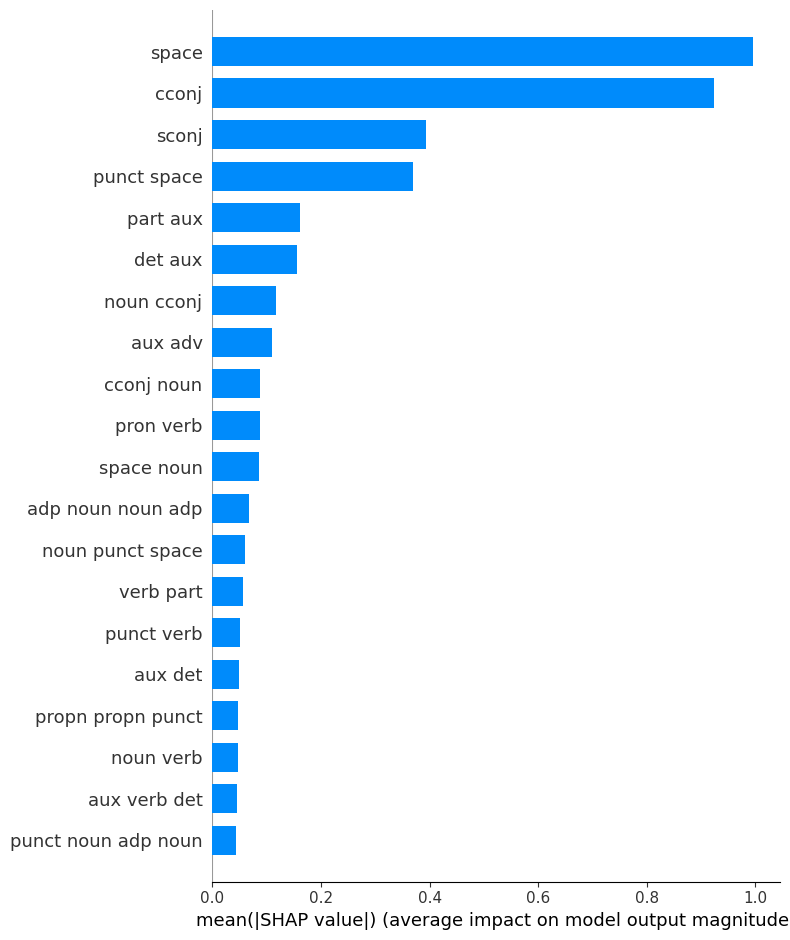

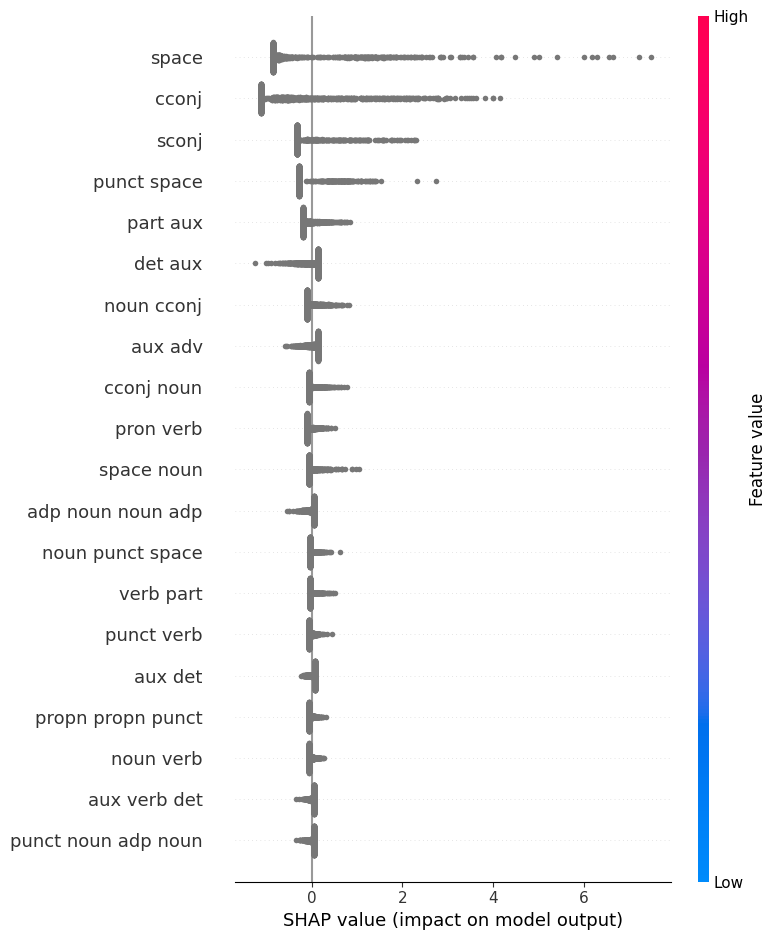

In [38]:
import shap

# Initialize SHAP
shap.initjs()

# Extract the model and the vectorizer from the pipeline
vectorizer = gs_clf.best_estimator_.named_steps['tfidf']
model = gs_clf.best_estimator_.named_steps['clf']

# Transform the test data
X_test_transformed = vectorizer.transform(X_test)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Create a SHAP explainer
explainer = shap.LinearExplainer(model, X_test_transformed, feature_perturbation="interventional")

# Compute SHAP values
shap_values = explainer(X_test_transformed)

# Plot the SHAP summary plots with feature names
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


In [4]:
from cube.api import Cube

cube_nlp = Cube(verbose=True)

cube_nlp.load("ro")



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a m

In [21]:
def get_pos_from_texts(texts):
    texts_upos = []
    texts_xpos = []
    for text in texts:
        tmic_upos = []
        tmic_xpos = []
        if len(text) > 512:
            try:
                small_text = ''
                text = text.split(' ')
                # print(1)
                while len(small_text) + len(text[0]) <= 512:
                    small_text += text[0] + ' '
                    text = text[1:]
                small_text = small_text.strip()
                text = ' '.join(text)
                doc = None
                # print(small_text)
                doc = cube_nlp(small_text).sentences
                
                # print(2)
                text_upos = []
                text_xpos = []
                for sent in doc:
                    for word in sent.words:
                        text_upos.append(word.upos)
                        text_xpos.append(word.xpos)
                
                # print(1)
                texts_upos.append([str(token) for token in text_upos])
                texts_xpos.append([str(token) for token in text_xpos])
            except Exception as e:
                # print(3)
                # print(small_text)
                # print(text)
                print(e)
                continue
        else:
            # print(3)
            try:
                doc = None
                doc = cube_nlp(text).sentences
            except:
                # print(4)
                continue
            
            # print(len(doc))
            # print(type(doc[0]))
            
            # break
            
            text_upos = []
            text_xpos = []
            for sent in doc:
                for word in sent.words:
                    text_upos.append(word.upos)
                    text_xpos.append(word.xpos)
            
            # print(2)
            texts_upos.append([str(token) for token in text_upos])
            texts_xpos.append([str(token) for token in text_xpos])
            
        
        print(len(texts_upos))
        
        
    return [texts_upos, texts_xpos]

print("ro-cube")
print(len(all_texts["romana"]))
upos_romana, xpos_romana = get_pos_from_texts(all_texts["romana"])

print("md-cube")
print(len(all_texts["moldova"]))
upos_moldova, xpos_moldova = get_pos_from_texts(all_texts["moldova"])

ro-cube
1018
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
list index out of range
27
28
list index out of range
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
list index out of range
46
47
48
list index out of range
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
list index out of range
89
90
91
92
93
94
95
96
97
list index out of range
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
list index out of range
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
list index out of range
222
223
224
225
226

In [22]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [23]:
# Train a classifier using the most common parts of speech
X = upos_romana + upos_moldova
y = ["romana"] * len(upos_romana) + ["moldova"] * len(upos_moldova)

X = np.array([' '.join(tag) for tag in X])
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=11)
text_clf = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(min_df=3, max_df=0.7, max_features=10000)),
        ('clf', LogisticRegression(penalty='l2'))
    ], verbose=True)
parameters = {
    'tfidf__ngram_range': [(1, 4)],
    'tfidf__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, verbose=1)

scores = []
gs_scores = []

for train_index, test_index in sss.split(X_train, y_train):
    X_train_split, X_test_split = X_train[train_index], X_train[test_index]
    y_train_split, y_test_split = y_train[train_index], y_train[test_index]
    gs_clf = gs_clf.fit(X_train_split, y_train_split)
    
    scores.append(gs_clf.score(X_test_split, y_test_split))
    gs_scores.append(gs_clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.0s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   2.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipel

In [24]:
print("Mean score: ", np.mean(scores))
print("Mean grid search score: ", np.mean(gs_scores))
print("Best parameters: ", gs_clf.best_params_)
print("Best score: ", gs_clf.best_score_)
print("Classification report: ", classification_report(y_test, gs_clf.predict(X_test), ))

Mean score:  0.8967532467532469
Mean grid search score:  0.9003901170351106
Best parameters:  {'clf__C': 10, 'tfidf__ngram_range': (1, 4), 'tfidf__use_idf': True}
Best score:  0.8941050130238084
Classification report:                precision    recall  f1-score   support

     moldova       0.90      0.99      0.94       612
      romana       0.93      0.55      0.69       157

    accuracy                           0.90       769
   macro avg       0.91      0.77      0.82       769
weighted avg       0.90      0.90      0.89       769



In [25]:
# Train a classifier using the most common parts of speech - independent
X = xpos_romana + xpos_moldova
y = ["romana"] * len(xpos_romana) + ["moldova"] * len(xpos_moldova)

X = np.array([' '.join(tag) for tag in X])
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=11)
text_clf = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(min_df=3, max_df=0.7, max_features=10000)),
        ('clf', LogisticRegression(penalty='l2'))
    ], verbose=True)
parameters = {
    'tfidf__ngram_range': [(1, 4)],
    'tfidf__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}
gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, verbose=1)

scores = []
gs_scores = []

for train_index, test_index in sss.split(X_train, y_train):
    X_train_split, X_test_split = X_train[train_index], X_train[test_index]
    y_train_split, y_test_split = y_train[train_index], y_train[test_index]
    gs_clf = gs_clf.fit(X_train_split, y_train_split)
    
    scores.append(gs_clf.score(X_test_split, y_test_split))
    gs_scores.append(gs_clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.5s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.4s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.4s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.2s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.8s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   3.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s
[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   4.0s
[Pipeline] ......

In [26]:
print("Mean score: ", np.mean(scores))
print("Mean grid search score: ", np.mean(gs_scores))
print("Best parameters: ", gs_clf.best_params_)
print("Best score: ", gs_clf.best_score_)
print("Classification report: ", classification_report(y_test, gs_clf.predict(X_test), ))

Mean score:  0.9454545454545453
Mean grid search score:  0.9547464239271781
Best parameters:  {'clf__C': 10, 'tfidf__ngram_range': (1, 4), 'tfidf__use_idf': False}
Best score:  0.9465077261540269
Classification report:                precision    recall  f1-score   support

     moldova       0.96      0.99      0.97       612
      romana       0.95      0.83      0.89       157

    accuracy                           0.96       769
   macro avg       0.95      0.91      0.93       769
weighted avg       0.96      0.96      0.96       769

